## 1 多层感知机：理论模型

### 1.1 隐藏层
多层感知机（Multi-layer Perceptron）在单层神经网络的基础上引入了一到多个隐藏层（hidden layer）。隐藏层位于输入层和输出层之间。下图展示了一个多层感知机的神经网络图，它含有一个隐藏层，该层中有5个隐藏单元。多层感知机中的隐藏层和输出层都是全连接层。

![avatar](../resource/mlp.svg)

### 1.2 矢量计算表达式
在不考虑激活函数的前提下，设输入样本$X \in \mathbb{R}^{n \times d}$，标签个数为$q$。对于仅包含单个隐藏层的神经网络，记隐藏层的输出为$H \in \mathbb{R}^{n \times h}$。则
$$
H = X W_h + b_h
$$
$$
O = H W_o + b_o,
$$
其中$W_h \in \mathbb{R}^{d \times h}$，$b_h \in \mathbb{R}^{1 \times h}$，$W_o \in \mathbb{R}^{h \times q}$，$b_o \in \mathbb{R}^{1 \times q}$分别为隐藏层和输出层的权重及偏置。

因此
$$
O = X W_h W_o + (b_h W_o + b_o),
$$
这相当于是一个权重为$W_h W_o$，偏置为$b_h W_o + b_o$的单层神经网络。

### 1.3 激活函数
全连接层只是对数据做仿射变换（affine transformation），而**多个仿射变换的复合仍然是一个仿射变换**。解决问题的一个方法是引入非线性变换，例如对隐藏变量使用按元素运算的非线性函数进行变换，然后再作为下一个全连接层的输入。这个非线性函数被称为激活函数（activation function）。

#### 1.3.1 ReLU（Rectified Linear Unit）
$$
ReLU(x) = \max (x, 0)
$$

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import my_utils

def xyplot(x_vals, y_vals, name):
    my_utils.use_svg_display()
    my_utils.set_figsize(figsize=(4, 2.5))
    plt.plot(x_vals.detach().numpy(), y_vals.detach().numpy())
    plt.xlabel('x')
    plt.ylabel(name + '(x)')

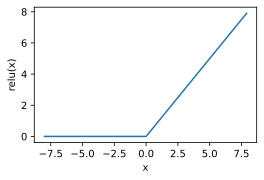

In [23]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = x.relu()
xyplot(x, y, 'relu')

ReLU的导数：
因为$\vec{y} = relu(\vec{x})$是矢量，PyTorch无法直接求梯度，因此可令$z = \sum_i y_i = \sum_i relu(x_i)$，则$\frac{\partial z}{\partial x_i} = \frac{\partial z}{\partial y_i} \cdot \frac{\partial y_i}{\partial x_i} = \frac{\partial y_i}{\partial x_i}$。

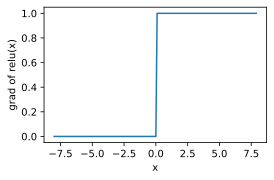

In [24]:
y.sum().backward()
xyplot(x, x.grad, 'grad of relu')

#### 1.3.2 sigmoid
$$
sigmoid (x) = \frac{1}{1 + \exp (-x)}
$$

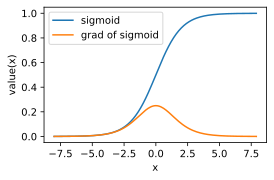

In [25]:
y = x.sigmoid()
xyplot(x, y, 'value')

x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'value')

plt.legend(['sigmoid', 'grad of sigmoid'])

#### 1.3.3 tanh
$$
tanh (x) = \frac{1 - \exp (-2x)}{1 + \exp (-2x)}
$$

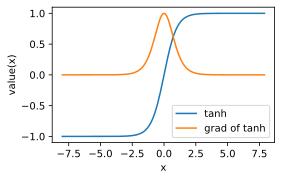

In [26]:
y = x.tanh()
xyplot(x, y, 'value')

x.grad.zero_()
y.sum().backward()
xyplot(x, x.grad, 'value')

plt.legend(['tanh', 'grad of tanh'])

### 1.4 多层感知机
多层感知机就是含有至少一个隐藏层的由全连接层组成的神经网络，且每个隐藏层的输出通过激活函数进行变换。多层感知机的层数和各隐藏层中隐藏单元个数都是超参数。以单隐藏层为例，
$$
H = \phi (X W_h + b_h)
$$
$$
O = H W_o + b_o
$$
在分类问题中，我们可以对输出$O$做softmax运算，并使用softmax回归中的交叉熵损失函数。在回归问题中，我们将输出层的输出个数设为$1$，并将输出$O$直接提供给线性回归中使用的平方损失函数。

## 2 多层感知机：从零开始实现

导入并读取数据集：

In [2]:
batch_size = 256
train_iter, test_iter = my_utils.load_fashion_mnist(batch_size)

初始化模型参数：

In [3]:
num_inputs = 784
num_outputs = 10
num_hiddens = 256

W1 = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_hiddens)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens, dtype=torch.float, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_outputs)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_outputs, dtype=torch.float, requires_grad=True)
params = [W1, b1, W2, b2]

### 2.1 定义ReLU激活函数

In [4]:
def relu(X):
    return torch.max(input=X, other=torch.tensor(0.0))

### 2.2 定义MLP模型

In [5]:
def net(X):
    X = X.view((-1, num_inputs))
    H = relu(torch.matmul(X, W1) + b1)
    return torch.matmul(H, W2) + b2

使用Torch自带的交叉熵损失函数：

In [6]:
loss = torch.nn.CrossEntropyLoss()

使用softmax回归章节定义的通用训练模型：

In [7]:
import my_utils
num_epochs, lr = 10, 80.0   # 这里lr的设置是反常的，因为my_utils中mgd的实现除以了batch_size
my_utils.general_train(net, train_iter, test_iter, loss, num_epochs, batch_size, params=params, lr=lr, optimizer=None)

epoch 1, loss 0.0031, train acc 0.711, test acc 0.792
epoch 2, loss 0.0019, train acc 0.823, test acc 0.828
epoch 3, loss 0.0017, train acc 0.844, test acc 0.840
epoch 4, loss 0.0016, train acc 0.853, test acc 0.808
epoch 5, loss 0.0015, train acc 0.861, test acc 0.849
epoch 6, loss 0.0014, train acc 0.868, test acc 0.863
epoch 7, loss 0.0014, train acc 0.872, test acc 0.833
epoch 8, loss 0.0013, train acc 0.877, test acc 0.857
epoch 9, loss 0.0013, train acc 0.881, test acc 0.852
epoch 10, loss 0.0012, train acc 0.883, test acc 0.863


## 3 多层感知机：PyTorch实现

In [8]:
import torch.nn as nn

num_inputs, num_hiddens, num_outputs = 784, 256, 10
net = torch.nn.Sequential(
    my_utils.FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(), 
    nn.Linear(num_hiddens, num_outputs)
)

for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

In [9]:
batch_size = 256
train_iter, test_iter = my_utils.load_fashion_mnist(batch_size)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
my_utils.general_train(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0035, train acc 0.671, test acc 0.742
epoch 2, loss 0.0020, train acc 0.815, test acc 0.771
epoch 3, loss 0.0017, train acc 0.842, test acc 0.832
epoch 4, loss 0.0016, train acc 0.854, test acc 0.816
epoch 5, loss 0.0015, train acc 0.861, test acc 0.838
epoch 6, loss 0.0014, train acc 0.868, test acc 0.840
epoch 7, loss 0.0014, train acc 0.871, test acc 0.856
epoch 8, loss 0.0013, train acc 0.877, test acc 0.859
epoch 9, loss 0.0012, train acc 0.883, test acc 0.866
epoch 10, loss 0.0012, train acc 0.885, test acc 0.865
